<a href="https://colab.research.google.com/github/adasegroup/ML2023_seminars/blob/master/seminar9/seminar_feature_model_selection_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Feature and Model Selection Seminar**  
### **Presented by: [Razan Dibo]**  
📅 **Date:** [20/02/2025]  
🏫 **Email/Affiliation:** [Razan.Dibo@skoltech.ru]  

## **Introduction**  
Feature selection and model selection are critical steps in machine learning to improve **model performance, reduce overfitting, and enhance interpretability**. This seminar explores key techniques for selecting **relevant features** and choosing the **best model** for a given task.

## **Contents**  
1- F-test

2- SHAP (SHapley Additive exPlanations)

3- Mutual Information

4- Random Forest based feature importances

5- Ordinary Least Squares (OLS) and T-Statistic for Feature Selection

6- L1 and L2 regularizations

7- Forward-backward methods

8- Permutation based feature importance

9- RFECV (Recursive Feature Elimination with Cross-Validation)

10- AIC and BIC

📌 **Objective:** By the end of this seminar, you will understand how to effectively select features to build efficient machine learning models.


# Feature selection

Feature selection is a fundamental step in machine learning that enhances model performance by identifying the most relevant features while discarding redundant or irrelevant ones. A well-applied feature selection strategy improves model efficiency, reduces computational complexity, and provides deeper insights into the underlying data structure. More importantly, it helps refine our intuition about how machine learning algorithms interact with data, leading to more interpretable and generalizable models.

Feature selection primarily helps in:

1️⃣ Reducing Dimensionality : Prevents overfitting, speeds up training, and improves model generalization.

2️⃣ Enhancing Interpretability : Identifies key features, improving insights into data and model transparency.

## **Toy Function**: Synthetic Example with Correlated and Noisy Features  

### Mathematical Representation of the Dataset  

We define a synthetic dataset with **10 features**, where only **3 features are truly informative**, **3 features are strongly correlated with the informative ones**, and **4 features are random noise**. The target variable \( y \) is generated as:  

$$
y = 3x_1^2 + 2\sin(2 \pi x_2) + 5\log(x_3 + 1) + \epsilon
$$  

We generate the dataset as the following table, where $ ϵ ~ \mathcal{N}(0,1)$:  


 **Feature Description**  

| Feature | Definition | Type | Relationship to $$ y $$ |
|----------|------------------------------|-------------------|----------------|
| $$ x_1 $$  | $$ \text{Uniform}(-3,3) $$  | **Informative**  | Quadratic term in $$ y $$ |
| $$ x_2 $$  | $$ \text{Uniform}(0,1) $$  | **Informative**  | Nonlinear sine transformation |
| $$ x_3 $$  | $$ \text{Uniform}(0,2) $$  | **Informative**  | Logarithmic contribution |
| $$ x_4 $$  | $$ \mathcal{N}(0,0.01) $$  | **Noise**  | Irrelevant to $$ y $$ |
| $$ x_5 $$  | $$ \text{Uniform}(-5,5) $$  | **Noise**  | Irrelevant to $$ y $$ |
| $$ x_6 $$  | $$ \text{Exponential}(1) $$  | **Noise**  | Irrelevant to $$ y $$ |
| $$ x_7 $$  | $$ \text{Integer}(-10,10) $$  | **Noise**  | Irrelevant to $$ y $$ |
| $$ x_8 $$  | $$ x_1 + \mathcal{N}(0,0.1) $$  | **Correlated**  | Strongly correlated with $$ x_1 $$ |
| $$ x_9 $$  | $$ 2x_2 + \mathcal{N}(0,0.2) $$  | **Correlated**  | Strongly correlated with $$ x_2 $$ |
| $$ x_{10} $$ | $$ \log(|x_3|) + \mathcal{N}(0,0.1) $$  | **Correlated**  | Strongly correlated with $$ x_3 $$ |



In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


def function(x, sigma_noise=1, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(42)

    y = (3 * x[:, 0]**2
         + 2 * np.sin(2 * np.pi * x[:, 1])
         + 5 * np.log(x[:, 2] + 1)
         + random_state.normal(0, sigma_noise, size=(len(x)))
         )
    return y

Let's generate training, validation and test sets

In [2]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
random_state = np.random.RandomState(42)
size = 1500

X = random_state.rand(size, 10)
print(X.shape)
X[:, 0] = 6 * X[:, 0] - 3
X[:, 1] = X[:, 1] # No change
X[:, 2] = 2 * X[:, 2]

# Add irrelevant features
X[:, 3] = random_state.normal(0, 0.01, size=(size))
X[:, 4] = 10 * X[:, 4] - 5
X[:, 5] = random_state.exponential(1, size=(size))
X[:, 6] = random_state.randint(-10, 10, size=(size))

# Add correlated features
X[:, 7] = X[:, 0] + random_state.normal(0, 0.1, size=(size))
X[:, 8] = 2 * X[:, 1] + random_state.normal(0, 0.2, size=(size))
X[:, 9] = np.log(np.abs(X[:, 2])) + random_state.normal(0, 0.1, size=(size))

y = function(X, sigma_noise=0.01, random_state=random_state)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=random_state)

print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")
print(f"y shape: {y.shape}")

(1500, 10)
X_train shape: (735, 10), X_val shape: (315, 10), X_test shape: (450, 10)
y shape: (1500,)


# 1. Fundamental Statistical Tests (Basic Evaluation of Feature Relevance)

1- F-test

2- Mutual Information

3- Ordinary Least Squares (OLS) and T-Statistic

## F-test based feature importances

F_regression creates simple linear regressions of each feature x and the dependent/target variable Y.

Each feature is tested individually, meaning if you have p features, it will test p separate models.

For each model, it computes how much variance in Y is explained by that feature versus how much is left unexplained (residual variance).


The F-statistic compares the variance explained by $X_j$ with the variance of the residuals. It is given by:

$ F = \frac{\text{Explained Variance by } X_j}{\text{Unexplained Variance (Residual Variance)}} $

Mathematically,

$ F = \frac{\frac{\text{SSR}}{1}}{\frac{\text{SSE}}{n - 2}} = \frac{\text{SSR} \cdot (n - 2)}{\text{SSE}} $

where:

- **SSR (Sum of Squares Regression)**: Variance explained by $X_j$:

  $ \text{SSR} = \sum (\hat{Y} - \bar{Y})^2 $

- **SSE (Sum of Squares Error)**: Variance not explained by $X_j$:

  $ \text{SSE} = \sum (Y - \hat{Y})^2 $

- $n$ is the number of samples.

This follows an F-distribution with degrees of freedom $(1, n - 2)$.

where:

- $Y$ represents the actual observed values.
- $\bar{Y}$ denotes the mean of the observed values.
- $\hat{Y}$ signifies the predicted values from the regression model.

Notes:

* higher F-statistic >> the feature explains more variance

* A higher F-value increases the likelihood of rejecting the null hypothesis (which states that the new features do not improve the model).


Now, let's apply F-test to the generated data and analyze results

In [4]:
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd

feature_names = np.array(
    ['x1', 'x2', 'x3', 'x4_irrelevant', 'x5_irrelevant', 'x6_irrelevant', 'x7_irrelevant',
     'x8_corr_x1', 'x9_corr_x2', 'x10_corr_x3']
)


f_values, p_values = f_regression(X_train, y_train)

feature_scores = pd.DataFrame({'F test': f_values, 'p-value': p_values}, index=feature_names)

scaler = MinMaxScaler() # yiu can use StandardScaler()
feature_scores['F test'] = scaler.fit_transform(feature_scores[['F test']])

feature_scores.style.format(precision=2).background_gradient(cmap='Reds', high=1.01)


,F test,p-value
x1,0.00,0.76
x2,0.66,0.00
x3,1.00,0.00
x4_irrelevant,0.02,0.47
x5_irrelevant,0.01,0.65
x6_irrelevant,0.01,0.51
x7_irrelevant,0.00,0.93
x8_corr_x1,0.00,0.75
x9_corr_x2,0.63,0.00
x10_corr_x3,0.81,0.00


**Conclusion**:
It only captures linear relationships.

It does not consider feature interactions.

If features are highly correlated, they may receive similar F-values.

## Mutual Information (MI)

Mutual Information measures how much information a feature $ X $ contains about the target variable $ Y $, capturing both linear and non-linear dependencies.

The formula for MI is:

$
MI(X, Y) = H(Y) - H(Y | X) = \sum_{x, y} p(x, y) \log \frac{p(x, y)}{p(x)p(y)} = D_{KL}(p(x, y) \, ||  \, p(x)p(y)),
$

### Key Insights:
- **$ MI(X, Y) = 0 $**: $ X $ and $ Y $ are **independent**.
- **Higher MI values**: Stronger **dependence** between $ X $ and $ Y $.


#### Let's compare F-test and Mutual Information

In [5]:
from sklearn.feature_selection import mutual_info_regression


method_name = 'Mutual Information'

#start here
# feature_scores[method_name] =
# scale it
feature_scores[method_name] = mutual_info_regression(X_train, y_train)

feature_scores = feature_scores.drop(columns=['p-value'])

feature_scores[method_name] = scaler.fit_transform(feature_scores[[method_name]])
# end here
feature_scores.style.format(precision=2).background_gradient(cmap='Reds', high=1.01)


,F test,Mutual Information
x1,0.00,1.00
x2,0.66,0.04
x3,1.00,0.07
x4_irrelevant,0.02,0.03
x5_irrelevant,0.01,0.00
x6_irrelevant,0.01,0.01
x7_irrelevant,0.00,0.00
x8_corr_x1,0.00,0.93
x9_corr_x2,0.63,0.02
x10_corr_x3,0.81,0.03


**Conclusion**:

- it can identify complex relationships between variables (non-linear).

- If features are highly correlated, they may receive all high MI values.

## Ordinary Least Squares (OLS) and T-Statistic for Feature Selection**

**Ordinary Least Squares (OLS)** is a fundamental regression method that estimates the relationship between independent variables ($X$) and a dependent variable ($y$). The OLS model minimizes the **sum of squared errors (SSE)** to find the best-fitting line:

$$
y =  X \beta+ \epsilon
$$

where:
- $\beta$ is the **feature coefficients**. $p * 1$
- $\epsilon$ is the **error term**. $n * 1$
- $ X $ is the predictors $n * p$
- $ y $ is observed values $n * 1$


The **t-statistic** evaluates the significance of each feature in the regression model using the formula:

$$
t_i = \frac{\hat{\beta}_i}{SE(\hat{\beta}_i)}
$$

where:
- $\hat{\beta}_i$ is the estimated coefficient.
- $SE(\hat{\beta}_i)$ is the standard error of the coefficient.

A **higher absolute t-statistic** ($|t| > 2$) and a **low p-value** ($ p < 0.05 $) indicate that the feature significantly contributes to the model.


In [6]:
import statsmodels.api as sm
# example
np.random.seed(0)
X_new = np.random.rand(100, 3)
y_new = 3*X_new[:, 0] + 5*X_new[:, 1] + 2*X_new[:, 2] + np.random.randn(100) * 0.5

X_new = sm.add_constant(X_new)

model_new = sm.OLS(y_new, X_new).fit()

coefficients = model_new.params
print(f'Feature coefficients: {coefficients}')
print(model_new.summary())

Feature coefficients: [-0.02489305  2.79566239  4.98997832  2.12661549]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     470.2
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           3.07e-57
Time:                        18:55:40   Log-Likelihood:                -65.325
No. Observations:                 100   AIC:                             138.7
Df Residuals:                      96   BIC:                             149.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

In [7]:
# Add intercept (bias term) for OLS model
X_sm = sm.add_constant(X_train)
y_sm = y_train

model = sm.OLS(y_sm, X_sm).fit()

print(model.summary())
#model.params
#model.tvalues
#model.pvalues

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     5.692
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           3.04e-08
Time:                        18:55:40   Log-Likelihood:                -2556.0
No. Observations:                 735   AIC:                             5134.
Df Residuals:                     724   BIC:                             5185.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.1499      1.323      9.181      0.0

In [8]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

X_train_scaled = scaler.fit_transform(X_train)

# Add intercept manually for OLS
X_train_scaled = sm.add_constant(X_train_scaled)

# Fit OLS model
model_scaled = sm.OLS(y_train, X_train_scaled).fit()

print(model_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     5.692
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           3.04e-08
Time:                        18:55:40   Log-Likelihood:                -2556.0
No. Observations:                 735   AIC:                             5134.
Df Residuals:                     724   BIC:                             5185.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8303      3.233      3.041      0.0

**Conclusion**:

- it's more suitable for linear relationships between the features and the target.

- If features are highly correlated, it can lead to unstable coefficient estimates.

# 2. Regularization-Based feature Selection (Shrinkage Methods)

Regularization adds penalty to a model in order to prevent overfitting and improve generalization.  

* Instead of minimizing a loss function $L(X,Y)$, we minimize $L(X,Y)+\alpha\|\beta\|$,
    * where $\beta$ is the vector of model coefficients,
    * $\|\cdot\|$ is typically L1 or L2 norm
    * $\alpha$ is a parameter, specifying the amount of regularization ($\alpha = 0$ implies no regularization).

- **L1 norm** ($\|\beta\|_1 = \sum |\beta_i|$) – used in **Lasso**.
- **L2 norm** ($\|\beta\|_2^2 = \sum \beta_i^2$) – used in **Ridge Regression**.



In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge

lasso = make_pipeline(StandardScaler(with_mean=False), Lasso(alpha=0.001)).fit(X_train, y_train)
feature_scores['Lasso'] = scaler.fit_transform(np.abs(lasso['lasso'].coef_).reshape(-1, 1))
feature_scores.style.format("{:.2}").background_gradient(cmap='Reds', high=1.01)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.056e+02, tolerance: 4.867e+00
  model = cd_fast.enet_coordinate_descent(


,F test,Mutual Information,Lasso
x1,0.0027,1.0,0.96
x2,0.66,0.044,0.52
x3,1.0,0.066,0.66
x4_irrelevant,0.016,0.028,0.14
x5_irrelevant,0.0062,0.0,0.0
x6_irrelevant,0.013,0.014,0.032
x7_irrelevant,0.0,0.0,0.033
x8_corr_x1,0.0029,0.93,1.0
x9_corr_x2,0.63,0.02,0.14
x10_corr_x3,0.81,0.034,0.18


### Task

What if we remove correlated component?

1. Build `RidgeRegression` model using all features. Check coefficients for features `x3` and `corr(x3)`.
2. Build `RidgeRegression` model without the last feature. Check coefficient for feature `x3`.
3. What can you conclude?

In [9]:
# start your code for all features
ridge = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=0.001)).fit(X_train, y_train)
feature_scores['Ridge'] = scaler.fit_transform(np.abs(ridge['ridge'].coef_).reshape(-1, 1))
feature_scores.style.format(precision=2).background_gradient(cmap='Reds', high=1.01)
# end your code

,F test,Mutual Information,Lasso,Ridge
x1,0.00,1.00,0.96,0.97
x2,0.66,0.04,0.52,0.41
x3,1.00,0.07,0.66,0.51
x4_irrelevant,0.02,0.03,0.14,0.11
x5_irrelevant,0.01,0.00,0.00,0.00
x6_irrelevant,0.01,0.01,0.03,0.03
x7_irrelevant,0.00,0.00,0.03,0.03
x8_corr_x1,0.00,0.93,1.00,1.00
x9_corr_x2,0.63,0.02,0.14,0.11
x10_corr_x3,0.81,0.03,0.18,0.14


In [10]:
# Your code here without last feature
model = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=1)).fit(X_train[:, :-1], y_train)
print(scaler.transform(np.abs(model['ridge'].coef_[[2]]).reshape(-1, 1)))

model = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=1)).fit(X_train, y_train)
print(scaler.transform(np.abs(model['ridge'].coef_[[2, -1]]).reshape(-1, 1)))
#np.sum(lasso['lasso'].coef_ == 0)

[[0.63209295]]
[[0.50683425]
 [0.141182  ]]


**Conclusion**:
* **Lasso** efficiently **zeros out** coefficients, RidgeRegression makes them smaller but typically non-zero.
* $\rightarrow$ Lasso can be used for feature selection by removing unimportatnt features.
* $\rightarrow$ Ridge can be used to control multicollinearity and to prevent overfitting

# 3. Model-Based feature Selection (Using ML models)

## Random Forest based feature importances

## Mean Decrease in Impurity (MDI) - Gini Importance

In Random Forests, feature importance can be calculated in different ways, and one of the most common methods is **Mean Decrease in Impurity (MDI)**, also known as **Gini Importance**.

MDI measures how much each feature contributes to reducing the impurity (or uncertainty) of the model’s predictions. This is done by examining how often a feature is used to split the data across all trees in the forest and how much it improves the model's performance.

The main idea behind MDI is that the more a feature is used in the decision-making process (splits), and the more it helps to reduce uncertainty or error in the predictions, the higher its importance.

How?

1. **Splitting Nodes**: In each decision tree, the algorithm splits the data at each node using a feature. The feature used for the split is selected based on how well it reduces impurity (Gini index).
  
2. **Calculating Gini Impurity**: For each split, the algorithm calculates the Gini impurity of the resulting child nodes. The Gini impurity measures how "impure" or mixed the resulting groups are after the split.
  
3. **Averaging Impurity Reduction**: For each feature, the importance is calculated by averaging how much the Gini impurity decreases each time the feature is used for splitting across all the trees in the forest.

4. **Final Feature Importance**: Features that reduce the Gini impurity more often and to a greater degree are assigned higher importance.


In [9]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

feature_scores['Random Forest'] = scaler.fit_transform(random_forest.feature_importances_.reshape(-1, 1))
feature_scores.style.format(precision=2).background_gradient(cmap='Reds', high=1.01)

,F test,Mutual Information,Random Forest
x1,0.00,1.00,1.00
x2,0.66,0.04,0.02
x3,1.00,0.07,0.02
x4_irrelevant,0.02,0.03,0.00
x5_irrelevant,0.01,0.00,0.00
x6_irrelevant,0.01,0.01,0.00
x7_irrelevant,0.00,0.00,0.00
x8_corr_x1,0.00,0.93,0.17
x9_corr_x2,0.63,0.02,0.00
x10_corr_x3,0.81,0.03,0.01


**Note**: If features are highly correlated, decision trees may often choose one feature over the other during splits because they essentially provide redundant information >>  can lead to biased importance rankings in the presence of collinearity

## Permutation Feature Importance (Mean Decrease in Accuracy - MDA)

Permutation Feature Importance, is a model-agnostic method for estimating the importance of each feature in a trained machine learning model. Unlike Mean Decrease in Impurity (MDI), which is based on decision trees, MDA evaluates feature importance by measuring the change in model performance when a feature's values are randomly shuffled (permuted).

#### How It Works:
1. **Train the Model**: A Random Forest (or any other model) is trained on the dataset.
2. **Calculate Baseline Accuracy**: The model's accuracy (or another performance metric, f1, R^2 etc.) is measured on a validation set.
3. **Feature Permutation**: The values of a single feature are randomly shuffled, breaking any relationship it had with the target variable.
4. **Recalculate Accuracy**: The model makes predictions using the modified dataset, and the new accuracy is recorded.
5. **Compute the Importance**: The difference between the baseline accuracy and the new accuracy after shuffling the feature represents its importance. A larger drop in accuracy indicates a more important feature.


### Task. Implement permutation importance

1. Using fitted model calculate its base_score - score, obtained using all features
2. Take one feature column and replace its values by the permuted values, calculate
   the score and subtract it from base_score, i.e. calculate `score_decrease`
3. Repeat step 2 several times and calculte mean `score_decrease`
4. Do steps 2 and 3 for each feature

In [10]:
def _permutation_importance(model, X, y,
                            feature, n_iters=5, random_state=None):
    """
    Calculate permutation importances for the given feature

    Parameters
    ==========
        model: sklearn-style fitted model with and score() methods
        X: ndarray - training inputs
        y: ndarray - training targets
        feature: int - index of feature for which importance should be
                       calculated
        n_iters: int - number of permutation rounds

    Returns
    =======
        ndarray: feature importances
    """
    if random_state is None:
        random_state = np.random.RandomState(42)
    if isinstance(random_state, int):
        random_state = np.random.RandomState(random_state)

    base_score = model.score(X, y)

    importance = None

    scores = []
    for i in range(n_iters):
        X_copy = X.copy()
    # start your code here
        # permutation =  # shuffle the rows of the original matrix and then replace each feature "column" by the new shuffled one
        permutation = random_state.permutation(X.shape[0])
        X_copy[:, feature] = X[permutation, feature]
        # calculate the drop in score
        scores.append(base_score - model.score(X_copy, y))

    # calculate the mean over the iterations
    importance = np.mean(scores)

    #end your code here
    return importance

def get_permutation_importance(model, X, y, n_iters=20, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(42)
    elif isinstance(random_state, int):
        random_state = np.random.RandomState(random_state)

    permutation_importances = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        permutation_importances[i] = _permutation_importance(model, X, y, i)
    return permutation_importances

In [11]:
random_forest = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)
permutation_importances = get_permutation_importance(random_forest, X_val, y_val)

feature_scores['Permutation Importance'] = scaler.fit_transform(permutation_importances.reshape(-1, 1))
feature_scores.style.format(precision=2).background_gradient(cmap='Reds', high=1.01)

,F test,Mutual Information,Random Forest,Permutation Importance
x1,0.00,1.00,1.00,1.00
x2,0.66,0.04,0.02,0.02
x3,1.00,0.07,0.02,0.02
x4_irrelevant,0.02,0.03,0.00,0.00
x5_irrelevant,0.01,0.00,0.00,0.00
x6_irrelevant,0.01,0.01,0.00,0.00
x7_irrelevant,0.00,0.00,0.00,0.00
x8_corr_x1,0.00,0.93,0.17,0.03
x9_corr_x2,0.63,0.02,0.00,0.00
x10_corr_x3,0.81,0.03,0.01,0.01


A bar plot can be used to visualize features importance

In [14]:
def plot_feature_scores(feature_names, scores):
    sorting_idx = np.argsort(scores)
    sorted_names = np.array(feature_names)[sorting_idx]

    plt.figure(figsize=(10, 0.3 * len(scores)))
    plt.barh(range(len(scores)), scores[sorting_idx], height=0.5)
    plt.yticks(range(len(scores)), sorted_names)

    for i, v in enumerate(scores[sorting_idx]):
        if np.isfinite(v):
            v_str = '{:.3f}'.format(v) if v != int(v) else '{}'.format(int(v))
            plt.text(v + 0.005 * scores.max(), i - 0.22, v_str)

    plt.grid(True)
    plt.ylim([-0.5, len(scores) - 0.5])
    plt.show()


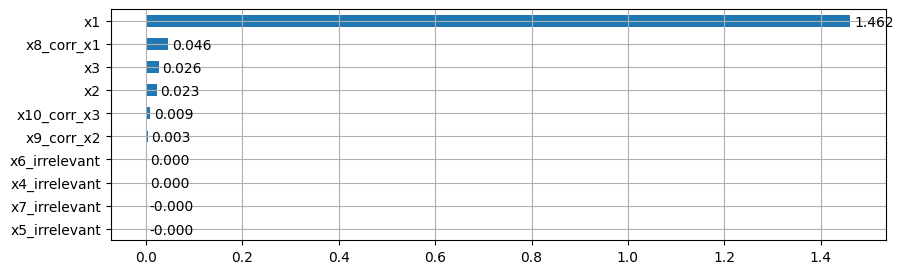

In [15]:
plot_feature_scores(feature_names, permutation_importances)

**Conclusion**:

Pros:
- Works with any model.
- Captures interactions between features since it evaluates importance based on the trained model’s behavior.

Cons
- Computationally expensive since it requires multiple evaluations.
- Can be biased if features are highly correlated, as shuffling one feature may not significantly impact the model if another correlated feature still provides similar information.

## SHAP (SHapley Additive exPlanations)

SHAP values are based on Shapley values from game theory, which help explain how much each feature contributes to a model's prediction.

The SHAP value for a feature $ x_i $ is computed as:

$
\phi_i = \sum_{S \subseteq F \setminus \{i\}} \frac{|S|! (|F| - |S| - 1)!}{|F|!} \left[ f(S \cup \{i\}) - f(S) \right]
$

Where:

- $ S $ is a subset of all features excluding feature $ i $ and $ |S| $ is its size.
- $ f(S) $ is the model’s prediction using only features in $ S $.
- $ f(S \cup \{i\}) $ is the prediction including feature $ i $.
- $ |F| $ is the total number of features.

This equation computes the average contribution of feature $ i $ across all possible feature subsets.

### SHAP with random forest

Selected Features: ['x1', 'x8_corr_x1', 'x3', 'x2', 'x10_corr_x3']


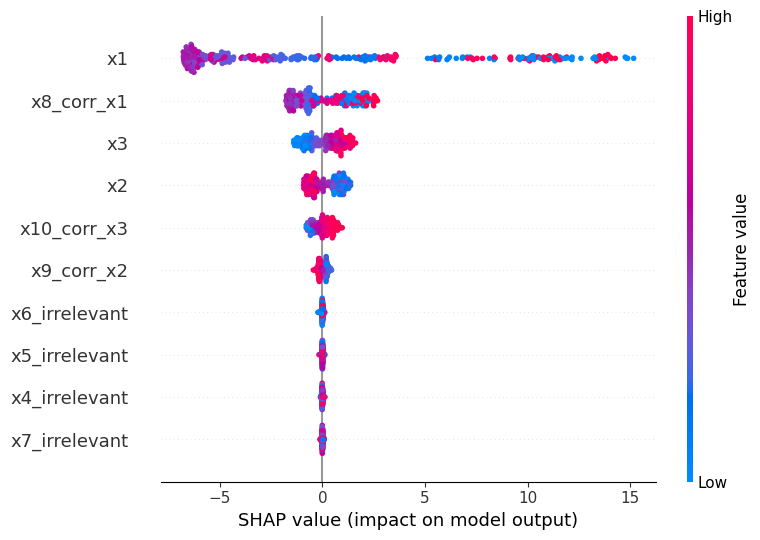

In [15]:
import shap

X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_val_df = pd.DataFrame(X_val, columns=feature_names)

model_rf = RandomForestRegressor(n_estimators=100).fit(X_train_df, y_train)

explainer_rf = shap.Explainer(model_rf, X_train_df )

shap_values = explainer_rf(X_val_df)

feature_importance_rf = np.abs(shap_values.values).mean(axis=0)

feature_ranking_rf = pd.Series(feature_importance_rf, index=feature_names).sort_values(ascending=False)

top_n = 5  # Adjust as needed
selected_features_rf = feature_ranking_rf.index[:top_n]

print("Selected Features:", selected_features_rf.tolist())

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_val_df)

### SHAP with xgboost

Selected Features: ['x1', 'x8_corr_x1', 'x2', 'x3', 'x10_corr_x3']


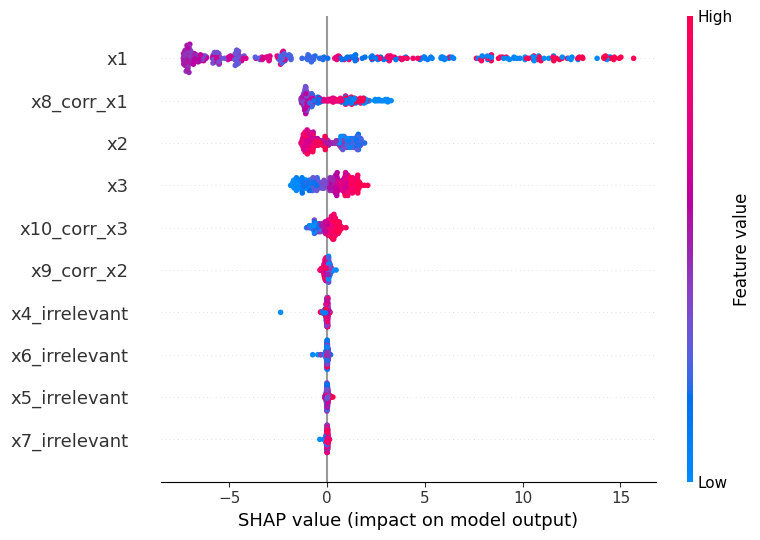

In [16]:

import xgboost

X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_val_df = pd.DataFrame(X_val, columns=feature_names)


model_xgb = xgboost.XGBRegressor().fit(X_train_df, y_train)

explainer_xgb = shap.Explainer(model_xgb, X_train_df)
shap_values = explainer_xgb(X_val_df)

feature_importance = np.abs(shap_values.values).mean(axis=0)

feature_ranking = pd.Series(feature_importance, index=feature_names).sort_values(ascending=False)


top_n = 5  # Adjust as needed
selected_features = feature_ranking.index[:top_n]

print("Selected Features:", selected_features.tolist())

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_val_df)

**Conclusion**:

Pros:

- It capture the feature interactions.

- It has fair distribution of importance among correlated Features


Cons

- Computationally expensive: many possible feature combinations.


# 4. Wrapper methods (iterative selection approaches)

Wrapper methods are feature selection techniques that evaluate subsets of features by training a model on them and assessing performance. The idea is to iteratively add or remove features and observe how a chosen evaluation metric changes.

Wrapper methods use the learning algorithm itself to assess feature importance.

Two types:

Forward Selection : Starts with an empty set of features and adds features one at a time, selecting the feature that improves the model the most.

Backward Elimination : Starts with all features and removes the least useful features one by one.

The decision on whether to add or remove a feature is based on different evaluation criteria:
- AIC
- BIC
- validation error
- Mallows $C_p$
- model.score()`

### Task. Implement forward method

Implement the following algorithm:

1. Start with empty list of features.
2. Add feature that increases model quality the most (use `model.score()` function)
3. Iterate step 2 until required number of features is selected


In [17]:
def forward_steps(X, y, n_features, model, X_test, y_test):
    """
    Parameters
    ==========
        X: ndarray - training inputs
        y: ndarray - training targets
        n_features: int - number of features to select
        model: sklearn model
        X_test: ndarray - test inputs
        y_test: ndarray - test targets

    Returns
    =======
        list - list of features
    """

    feat_list = []

    # Your code here

    # fill variable feat_list with
    # the selected features and return it

    for i in range(n_features):
        max_score = -np.inf
        active_idx = -1
        for j in range(X.shape[1]):
            if j not in feat_list:
                feat_list.append(j)

                model.fit(X[:, feat_list], y)
                current_score = model.score(X_test[:, feat_list], y_test)

                feat_list.pop()

                if current_score > max_score:
                    max_score = current_score
                    active_idx = j
        feat_list.append(active_idx)

        print('{:.2f}: {}'.format(max_score, feat_list))
    return feat_list

In [18]:
features_idx = forward_feat = forward_steps(X_train, y_train, 5,
                                            random_forest,
                                            X_test, y_test)
print(feature_names[features_idx])

0.91: [0]
0.96: [0, 2]
0.99: [0, 2, 1]
0.99: [0, 2, 1, 9]
0.99: [0, 2, 1, 9, 8]
['x1' 'x3' 'x2' 'x10_corr_x3' 'x9_corr_x2']


### Task 2. Use RFECV (Recursive Feature Elimination with Cross-Validation) to get optimal number of features

To choose number of features automatically, RFECV module may be used.

In [19]:
from sklearn.feature_selection import RFECV

# use RFECV to select features
rfe = RFECV(random_forest, n_jobs=-1, verbose=True, step=1, cv=3)
rfe.fit(X_train, y_train)

print(f"Optimal number of features: {rfe.n_features_}")
print(f"Selected features: {rfe.support_}")
print(f"Ranking of features: {rfe.ranking_}")

feature_scores['RFECV'] = scaler.fit_transform(-rfe.ranking_.astype(float).reshape(-1, 1))
feature_scores.style.format(precision=2).background_gradient(cmap='Reds', high=1.01)

#Optional: Use the selected features for training
#X_train_selected = X_train[:, rfecv.support_]
#X_test_selected = X_test[:, rfecv.support_]

# Fit model again using only selected features
#model.fit(X_train_selected, y_train)


Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Optimal number of features: 4
Selected features: [ True  True  True False False False False  True False False]
Ranking of features: [1 1 1 5 4 7 6 1 3 2]


,F test,Mutual Information,Lasso,Ridge,Random Forest,Permutation Importance,RFECV
x1,0.00,1.00,0.96,0.97,1.00,1.00,1.00
x2,0.66,0.04,0.52,0.41,0.02,0.02,1.00
x3,1.00,0.07,0.66,0.51,0.02,0.02,1.00
x4_irrelevant,0.02,0.03,0.14,0.11,0.00,0.00,0.33
x5_irrelevant,0.01,0.00,0.00,0.00,0.00,0.00,0.50
x6_irrelevant,0.01,0.01,0.03,0.03,0.00,0.00,0.00
x7_irrelevant,0.00,0.00,0.03,0.03,0.00,0.00,0.17
x8_corr_x1,0.00,0.93,1.00,1.00,0.17,0.03,1.00
x9_corr_x2,0.63,0.02,0.14,0.11,0.00,0.00,0.67
x10_corr_x3,0.81,0.03,0.18,0.14,0.01,0.01,0.83


### Task. Calculate quality of the model with the selected features


* Use RandomForestRegression
* Use test set and model's `score()` function to calculate model error
* Try F-test, RandomForest embedded feature importances, Permutation Importance and RFECV
* Select 5 features for each feature importance method

In [20]:
def compare_methods(model, X_train, y_train, X_val, y_val, X_test, y_test, feature_names):
    methods = {
        'F test': lambda X, y, X_val, y_val: f_regression(X, y)[0],

        'RandomForest': lambda X, y, X_val, y_val: model.fit(X, y).feature_importances_,

        'PermutationImportance': lambda X, y, X_val, y_val: get_permutation_importance(
            model.fit(X, y), X_val, y_val),

        'RFECV': lambda X, y, X_val, y_val: -RFECV(
            model, n_jobs=-1, step=1, cv=3).fit(X, y).ranking_
    }

    #model_scores = pd.DataFrame(columns=list(methods.keys()))
    model_scores = {}

    for fs_method in methods:
        scores = methods[fs_method](X_train, y_train, X_val, y_val)
        features_idx = np.argsort(-scores)[:5]
        # Print top feature names
        top_feature_names = [feature_names[i] for i in features_idx]
        print(f"🔹 **{fs_method} - Top 5 Features:** {top_feature_names}\n")
        model.fit(X_train[:, features_idx], y_train)
        model_scores[fs_method] = [model.score(X_test[:, features_idx], y_test)]

    return model_scores

In [21]:
compare_methods(random_forest, X_train, y_train, X_val, y_val, X_test, y_test, feature_names)

🔹 **F test - Top 5 Features:** ['x3', 'x10_corr_x3', 'x2', 'x9_corr_x2', 'x4_irrelevant']

🔹 **RandomForest - Top 5 Features:** ['x1', 'x8_corr_x1', 'x3', 'x2', 'x10_corr_x3']

🔹 **PermutationImportance - Top 5 Features:** ['x1', 'x8_corr_x1', 'x3', 'x2', 'x10_corr_x3']

🔹 **RFECV - Top 5 Features:** ['x1', 'x2', 'x3', 'x8_corr_x1', 'x10_corr_x3']



{'F test': [-0.07577470709989598],
 'RandomForest': [0.986460460871047],
 'PermutationImportance': [0.9865124389427276],
 'RFECV': [0.9866180688238027]}

In [ ]:
results = [compare_methods(random_forest, X_train, y_train, X_val, y_val, X_test, y_test) for _ in range(10)]

In [ ]:
pd.concat(results, axis=0, ignore_index=True).describe()

,F test,RandomForest,PermutationImportance,RFECV
count,10.000000,10.000000,10.000000,10.000000
mean,-0.074634,0.986551,0.986267,0.986440
std,0.007132,0.000257,0.000342,0.000127
min,-0.086328,0.986137,0.985751,0.986223
25%,-0.076708,0.986409,0.986025,0.986349
50%,-0.074205,0.986532,0.986228,0.986461
75%,-0.070591,0.986796,0.986455,0.986506
max,-0.063550,0.986859,0.986866,0.986643


###Test on new dataset (california_housing)

In [22]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()

df = pd.DataFrame(data.data, columns=data.feature_names)
df['Target'] = data.target
print(df.head())


X_cal, y_cal = data.data, data.target

feature_names_cal = data.feature_names

X_train_cal, X_temp, y_train_cal, y_temp = train_test_split(X_cal, y_cal, test_size=0.4, random_state=42)
X_val_cal, X_test_cal, y_val_cal, y_test_cal = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  Target  
0    -122.23   4.526  
1    -122.22   3.585  
2    -122.24   3.521  
3    -122.25   3.413  
4    -122.25   3.422  


In [23]:
compare_methods(random_forest, X_train_cal, y_train_cal, X_val_cal, y_val_cal, X_test_cal, y_test_cal, feature_names= feature_names_cal)

🔹 **F test - Top 5 Features:** ['MedInc', 'AveRooms', 'Latitude', 'HouseAge', 'Longitude']

🔹 **RandomForest - Top 5 Features:** ['MedInc', 'AveOccup', 'Longitude', 'Latitude', 'HouseAge']

🔹 **PermutationImportance - Top 5 Features:** ['MedInc', 'Latitude', 'Longitude', 'AveOccup', 'HouseAge']

🔹 **RFECV - Top 5 Features:** ['MedInc', 'AveRooms', 'AveOccup', 'Latitude', 'Longitude']



{'F test': [0.7952346977143988],
 'RandomForest': [0.8026570391622138],
 'PermutationImportance': [0.8023963217358917],
 'RFECV': [0.8030867592504145]}

# Bonus Task

# Information Criteria-Based Selection (Balancing Fit and Complexity)


### Akaike Information Criterion (AIC)

Akaike Information Criterion (**AIC**) is a measure used for **model selection**, balancing **good fit** and **low complexity** to prevent overfitting. It is based on information theory and estimates the relative quality of statistical models for a given dataset.

#### Mathematical Formula
$
\mathrm{AIC} = 2k - 2\ln(\hat{L})
$
where:  
- $ k $ = Number of estimated parameters in the model (complexity).  
- $ \hat{L} $ = Maximum value of the likelihood function (model fit).  

#### Notes:
- **Minimizing AIC** → Indicates a model that achieves good fit **without unnecessary complexity**.  
- **AIC rewards likelihood** (better fit improves AIC).  
- **AIC penalizes complexity** (more parameters increase AIC, discouraging overfitting).  

#### Theoretical Foundation (Information Theory)
AIC is derived from **Kullback–Leibler (KL) divergence**, which measures the information loss when approximating the true data-generating process \( f \) with a model \( M \).  
Given two candidate models, \( M_1 \) and \( M_2 \), AIC provides an estimate of the additional information lost when using \( M_1 \) instead of \( M_2 \).  

**AIC is valid only asymptotically** and should be used for comparing models fitted on the same dataset.  



### Bayesian Information Criterion (BIC)

The **Bayesian Information Criterion (BIC)** is a model selection criterion used to compare different models by balancing **good fit** and **low complexity**. It is similar to AIC but applies a **stronger penalty** for model complexity, especially when the sample size is large.

#### Mathematical Formula
$
BIC = k \ln(n) - 2\ln(\hat{L})
$
where:  
- $k$ = Number of estimated parameters (model complexity).  
- $n$ = Number of data points (sample size).  
- $ \hat{L} $ = Maximum likelihood of the model (fit quality).  

#### How to Interpret BIC?
- **Lower BIC values indicate better models** (if they are not overly complex).  
- **BIC penalizes complexity more than AIC**, favoring simpler models as \( n \) increases.  
- **Used to compare models** on the same dataset.  

####  **AIC vs. BIC**
| **Criterion** | **AIC** | **BIC** |
|--------------|--------|--------|
| **Formula** | $2k - 2\ln(L) $ | $ k \ln(n) - 2\ln(L) $ |
| **Penalty on Complexity** | Moderate | Stronger (depends on \( n \)) |
| **Model Preference** | Allows more complexity | Prefers simpler models for large \( n \) |

**BIC is best suited for cases where avoiding overfitting is critical.


### Task 4. Use LassoLarsIC to choose optimal alpha based on AIC and BIC

LassoLarsIC (Lasso Least Angle Regression with Information Criterion) is a method for selecting the optimal regularization parameter $$in Lasso regression.
It automatically finds the best α by minimizing either AIC or BIC.

#### What is α in Lasso?

α is the regularization parameter that controls the amount of shrinkage applied to the regression coefficients.

Higher α >> more regularization → More coefficients shrink to zero (simpler model).

Lower  α >> less regularization → More non-zero coefficients (more complex model).

#### Why Use AIC and BIC to Select α?
AIC and BIC help choose the best α by balancing model fit and complexity.

AIC favors models with better predictive performance (even if slightly more complex).

BIC favors simpler models, penalizing complexity more strongly.


**Task**:
1. choose $\alpha$ using AIC, print non-zero feature's names
2. choose $\alpha$ using BIC, print non-zero feature's names
3. Compare

In [17]:
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
# start your code here
# print non-zero features and alpha value, better to scale the features first
lasso_aic = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC('aic'))
lasso_aic.fit(X_train, y_train)
print(feature_names[np.where(lasso_aic['lassolarsic'].coef_)])

optimal_alpha = lasso_aic.named_steps['lassolarsic'].alpha_
print("Optimal alpha selected by AIC:", optimal_alpha)

['x2' 'x3' 'x4_irrelevant' 'x9_corr_x2' 'x10_corr_x3']
Optimal alpha selected by AIC: 0.09155714925069174


In [18]:
# start your code here
# print non-zero features and alpha value, better to scale the features first

lasso_bic = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC('bic'))
lasso_bic.fit(X_train, y_train)
print(feature_names[np.where(lasso_bic['lassolarsic'].coef_)])

optimal_alpha = lasso_bic.named_steps['lassolarsic'].alpha_
print("Optimal alpha selected by BIC:", optimal_alpha)


['x2' 'x3']
Optimal alpha selected by BIC: 0.7817845743115706


#### Note: both are weak to capture non linear features